##### Business Goals: 
Predict if the page is being flipped using a single image.

##### Success Metrics: 
Evaluate model performance based on F1 score, the higher the better.

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
#import libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer, ReLU, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
    
import warnings
warnings.filterwarnings('ignore')

#### Image Preprocessing

In [2]:
#Set a seed value
seed_value= 12321 

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [3]:
# define function to read images from folder
def read_images(folder):
    images = []
    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ##convert images from BGR to RGB
        if img is not None:
            img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
            y,h,x,w = 0,100,0,70
            img = img[y:y+h, x:x+w]
            img = img/255
            images.append(img)

    return images

In [4]:
#read the training data images
train_notflip = read_images("images/training/0")
train_flip = read_images("images/training/1")

X_noflip = np.array(train_notflip)
X_flip = np.array(train_flip)

y_noflip = np.zeros(X_noflip.shape[0])
y_flip = np.ones(X_flip.shape[0])

X = np.concatenate((X_noflip,X_flip ))
y = np.concatenate((y_noflip, y_flip))

X.shape, y.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [00:31<00:00, 36.37it/s]


((2392, 100, 70, 3), (2392,))

In [5]:
# read the testing data images
test_notflip = read_images("images/testing/0")
test_flip = read_images("images/testing/1")

X_test_noflip = np.array(test_notflip)
X_test_flip = np.array(test_flip)
y_test_noflip = np.zeros(X_test_noflip.shape[0])
y_test_flip = np.ones(X_test_flip.shape[0])


X_test = np.concatenate((X_test_noflip,X_test_flip ))
y_test = np.concatenate((y_test_noflip, y_test_flip))
X_test.shape, y_test.shape

100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:07<00:00, 36.55it/s]


((597, 100, 70, 3), (597,))

In [6]:
#define test and train images
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.2, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1913, 100, 70, 3), (479, 100, 70, 3), (1913,), (479,))

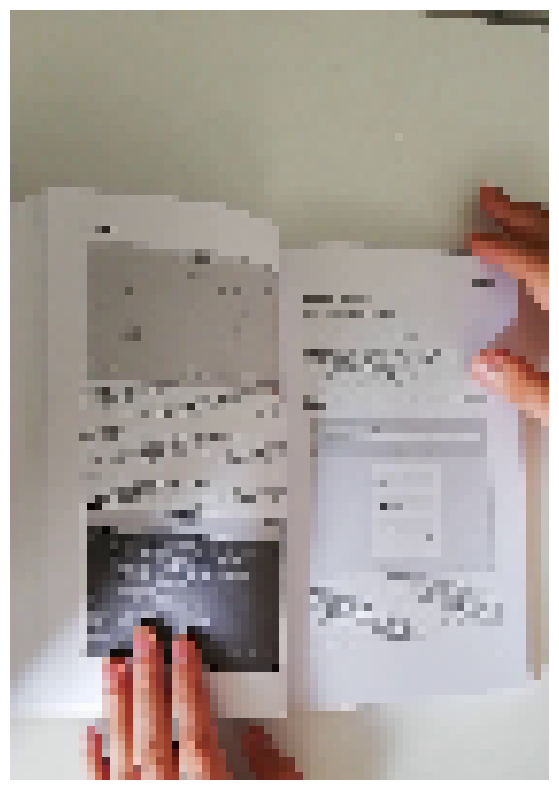

In [7]:
# visualizing the image
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(1,1,1)
plt.imshow(X_train[1], cmap="gray")
plt.axis('off')
plt.show()

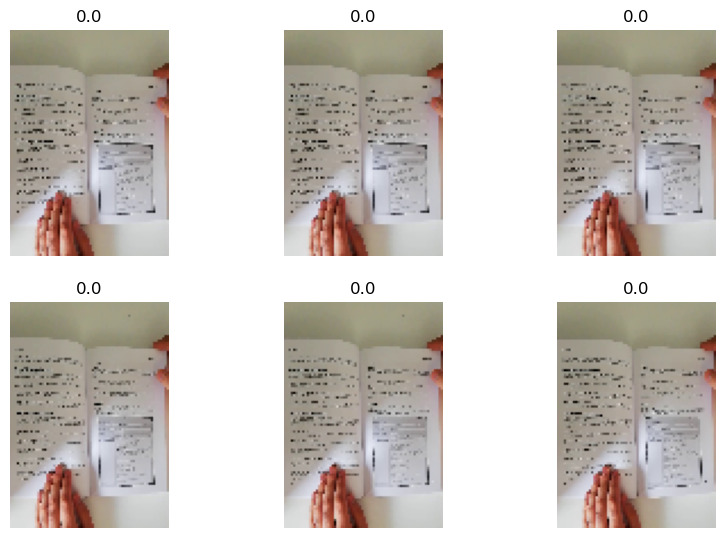

In [8]:
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis("off")

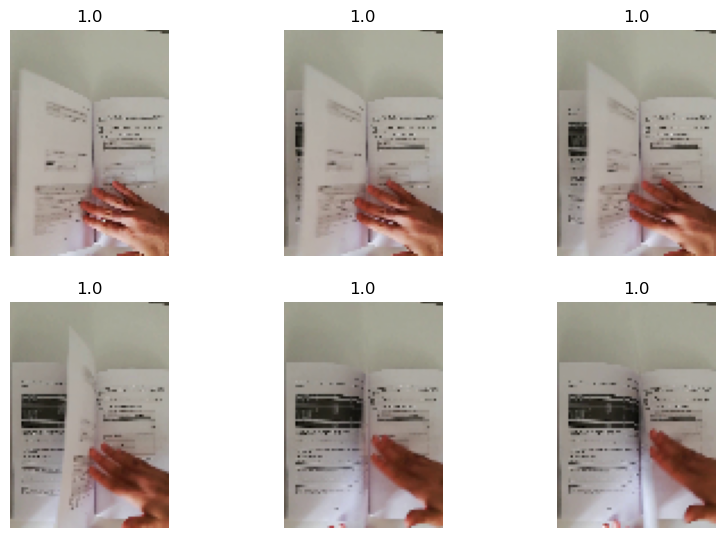

In [9]:
plt.figure(figsize=(10, 10))
for i in range(-6, 0):
    ax = plt.subplot(3, 3, 0 - i)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis("off")

In [10]:
# Define model parameters
model = Sequential()
model.add(Conv2D(32, (2, 2), activation = ReLU(), padding = 'same', input_shape=(100, 70,3)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation=ReLU()))
model.add(Dense(1, activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss=losses.binary_crossentropy, optimizer=adam, metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 70, 32)       416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 35, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 56000)             0         
                                                                 
 dense (Dense)               (None, 64)                3584064   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,584,545
Trainable params: 3,584,545
Non-trainable params: 0
______________________________________________

In [12]:
history_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=12, batch_size=64, verbose=1)

Epoch 1/12
30/30 [==============================] - 10s 59ms/step - loss: 0.9500 - accuracy: 0.4909 - val_loss: 0.6419 - val_accuracy: 0.5470
Epoch 2/12
30/30 [==============================] - 1s 18ms/step - loss: 0.5547 - accuracy: 0.7209 - val_loss: 0.5276 - val_accuracy: 0.6681
Epoch 3/12
30/30 [==============================] - 1s 20ms/step - loss: 0.4101 - accuracy: 0.8447 - val_loss: 0.3350 - val_accuracy: 0.9207
Epoch 4/12
30/30 [==============================] - 1s 19ms/step - loss: 0.2885 - accuracy: 0.9247 - val_loss: 0.2378 - val_accuracy: 0.9666
Epoch 5/12
30/30 [==============================] - 1s 19ms/step - loss: 0.2061 - accuracy: 0.9603 - val_loss: 0.1842 - val_accuracy: 0.9603
Epoch 6/12
30/30 [==============================] - 1s 18ms/step - loss: 0.1656 - accuracy: 0.9639 - val_loss: 0.1397 - val_accuracy: 0.9812
Epoch 7/12
30/30 [==============================] - 1s 19ms/step - loss: 0.1258 - accuracy: 0.9770 - val_loss: 0.1238 - val_accuracy: 0.9687
Epoch 8/12
3

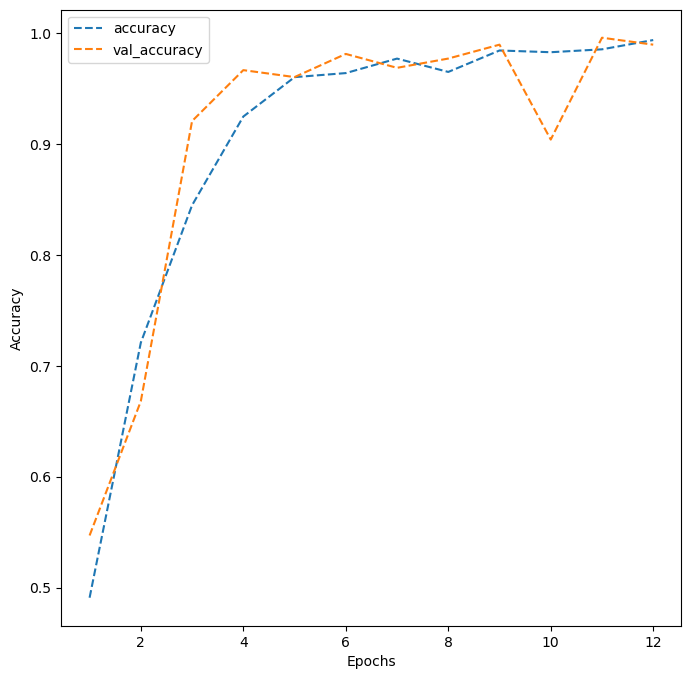

In [13]:
# plotting the accuracies

dict_hist = history_model.history
list_ep = [i for i in range(1,13)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'
                          ],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
train_pred = model.predict(X_train, verbose=1)


# Choose a threshold of 0.5
threshold = 0.5

# Convert probabilities to predicted labels
train_pred_labels = np.where(train_pred >= threshold, 1, 0)
#test_pred_labels1"

60/60 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1005
         1.0       1.00      0.99      1.00       908

    accuracy                           1.00      1913
   macro avg       1.00      1.00      1.00      1913
weighted avg       1.00      1.00      1.00      1913



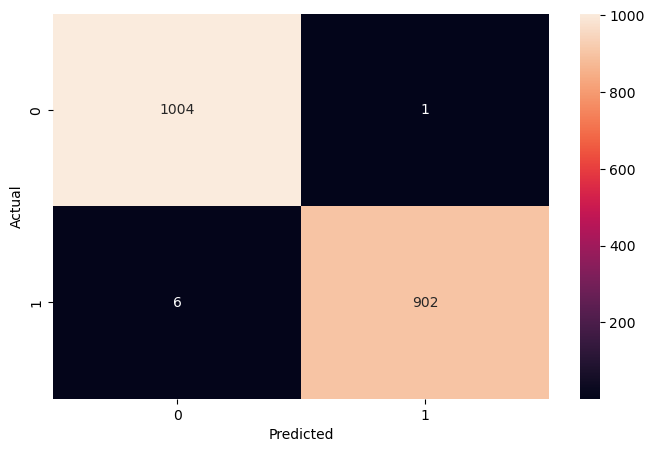

In [15]:
#Printing the classification report
print(classification_report(y_train, train_pred_labels))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_train, train_pred_labels)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
test_pred = model.predict(X_test, verbose=1)


# Choose a threshold of 0.5
threshold = 0.5

# Convert probabilities to predicted labels
test_pred_labels = np.where(test_pred >= threshold, 1, 0)
#test_pred_labels1"

19/19 [==============================] - 0s 17ms/step


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       307
         1.0       0.99      0.99      0.99       290

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



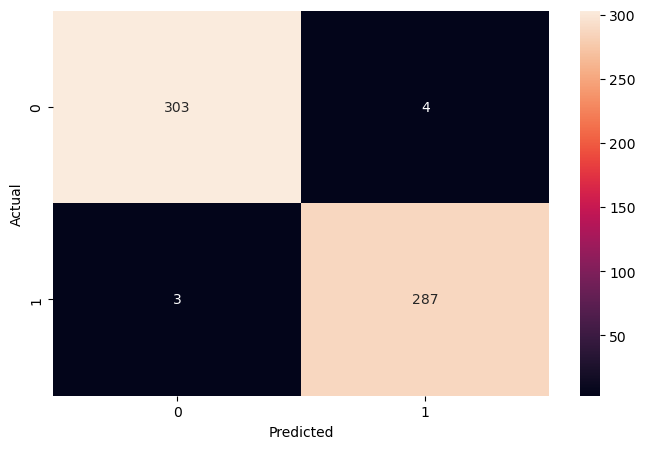

In [16]:
#Printing the classification report
print(classification_report(y_test, test_pred_labels))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, test_pred_labels)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
from sklearn.metrics import roc_curve, auc

In [26]:
##Print AUC curve
# Predict the probabilities for the test set
y_prob = model.predict(X_test)

19/19 [==============================] - 0s 11ms/step


In [29]:
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [30]:
# Calculate the AUC
roc_auc = auc(fpr, tpr)

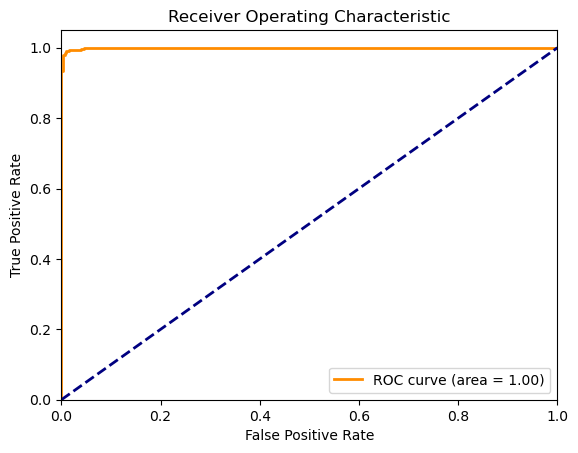

In [31]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [17]:
model.save("../models/ggg.h5") #save the model in a file

##### Define classes to process and classify the images (Image processor wrapped in a class)

In [32]:
## 3 files read process, train inference, then we need file for pre-trained model

import cv2
import os
from tqdm import tqdm

class ImageProcessor:
    def __init__(self, size=(70, 140)):
        self.size = size
        self.crop_coords = (0, 100, 0, 70)

    def process(self, folder):
        images = []
        for filename in tqdm(os.listdir(folder)):
            img = cv2.imread(os.path.join(folder,filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ##convert images from BGR to RGB
            if img is not None:
                img = cv2.resize(img, dsize=self.size, interpolation=cv2.INTER_CUBIC)
                y, h, x, w = self.crop_coords
                img = img[y:y+h, x:x+w]
                img = img/255
                images.append(img)



        return images

In [33]:
## Train the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU
from tensorflow.keras import losses, optimizers
import numpy as np

class CNNModel:
    def __init__(self, input_shape=(100, 70, 3)):
        self.model = Sequential()
        self.model.add(Conv2D(32, (2, 2), activation=ReLU(), padding='same', input_shape=input_shape))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation=ReLU()))
        self.model.add(Dense(1, activation='sigmoid'))
        adam = optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss=losses.binary_crossentropy, optimizer=adam, metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, epochs=12, batch_size=64, verbose=1):
        self.history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=epochs, batch_size=batch_size, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X) 

In [34]:
processor = ImageProcessor()

X_noflip =np.array(processor.process('../images/training/0'))
X_flip = np.array(processor.process('../images/training/1'))

y_noflip = np.zeros(X_noflip.shape[0])
y_flip = np.ones(X_flip.shape[0])

X = np.concatenate((X_noflip,X_flip ))
y = np.concatenate((y_noflip, y_flip))

X.shape, y.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1162/1162 [00:24<00:00, 47.86it/s]


((2392, 100, 70, 3), (2392,))

In [35]:
X_test_noflip = np.array(processor.process('../images/testing/0'))
X_test_flip = np.array(processor.process('../images/testing/1'))

y_test_noflip = np.zeros(X_test_noflip.shape[0])
y_test_flip = np.ones(X_test_flip.shape[0])


X_test = np.concatenate((X_test_noflip,X_test_flip ))
y_test = np.concatenate((y_test_noflip, y_test_flip))
X_test.shape, y_test.shape

100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:06<00:00, 48.05it/s]


((597, 100, 70, 3), (597,))

In [36]:
X.shape, y.shape

((2392, 100, 70, 3), (2392,))

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.2, shuffle=True)

In [38]:
cnn = CNNModel()
cnn.train(X_train, y_train, X_val, y_val)

Epoch 1/12
30/30 [==============================] - 1s 26ms/step - loss: 1.1054 - accuracy: 0.5426 - val_loss: 0.6630 - val_accuracy: 0.5282
Epoch 2/12
30/30 [==============================] - 1s 17ms/step - loss: 0.5926 - accuracy: 0.7041 - val_loss: 0.5488 - val_accuracy: 0.7453
Epoch 3/12
30/30 [==============================] - 1s 18ms/step - loss: 0.5223 - accuracy: 0.7386 - val_loss: 0.5080 - val_accuracy: 0.6701
Epoch 4/12
30/30 [==============================] - 1s 18ms/step - loss: 0.4181 - accuracy: 0.8489 - val_loss: 0.3874 - val_accuracy: 0.9040
Epoch 5/12
30/30 [==============================] - 1s 18ms/step - loss: 0.3333 - accuracy: 0.9174 - val_loss: 0.3542 - val_accuracy: 0.8434
Epoch 6/12
30/30 [==============================] - 1s 18ms/step - loss: 0.3014 - accuracy: 0.9080 - val_loss: 0.2959 - val_accuracy: 0.8852
Epoch 7/12
30/30 [==============================] - 1s 17ms/step - loss: 0.2348 - accuracy: 0.9493 - val_loss: 0.2320 - val_accuracy: 0.9353
Epoch 8/12
30

In [39]:
test_pred = cnn.predict(X_test)


# Choose a threshold of 0.5
threshold = 0.5

# Convert probabilities to predicted labels
test_pred_labels = np.where(test_pred >= threshold, 1, 0)
#test_pred_labels1

19/19 [==============================] - 0s 16ms/step


              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       307
         1.0       0.98      0.96      0.97       290

    accuracy                           0.97       597
   macro avg       0.97      0.97      0.97       597
weighted avg       0.97      0.97      0.97       597



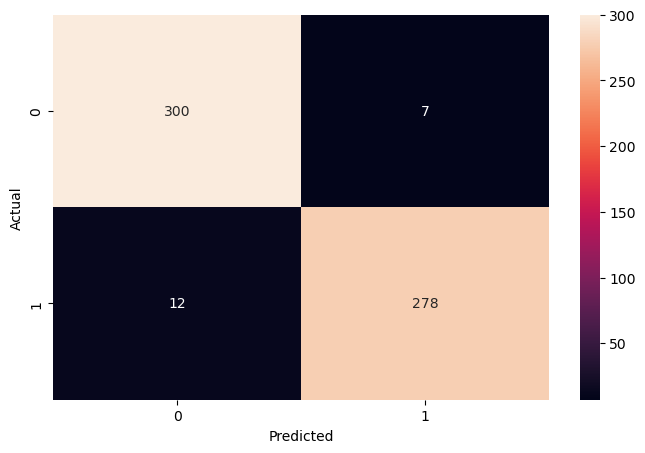

In [40]:
#Printing the classification report
print(classification_report(y_test, test_pred_labels))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, test_pred_labels)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [41]:
tf.keras.backend.clear_session()

In [42]:
print(classification_report(y_test, test_pred_labels))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       307
         1.0       0.98      0.96      0.97       290

    accuracy                           0.97       597
   macro avg       0.97      0.97      0.97       597
weighted avg       0.97      0.97      0.97       597

